In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
# 1. CARREGAMENTO DO DATASET

try:
    df = pd.read_csv('ESport_Earnings.csv', encoding='latin-1')
except FileNotFoundError:
    print("Arquivo não encontrado.")
    df = pd.DataFrame()

In [3]:
# Limpeza básica
df = df[df['Releaseyear'] > 1980].copy()
df['YearsActive'] = 2021 - df['Releaseyear']
df['Top_Country'] = df['Top_Country'].fillna('Unknown')

median_earn = df['TotalMoney'].median()
df['HighEarner'] = (df['TotalMoney'] > median_earn).astype(int)

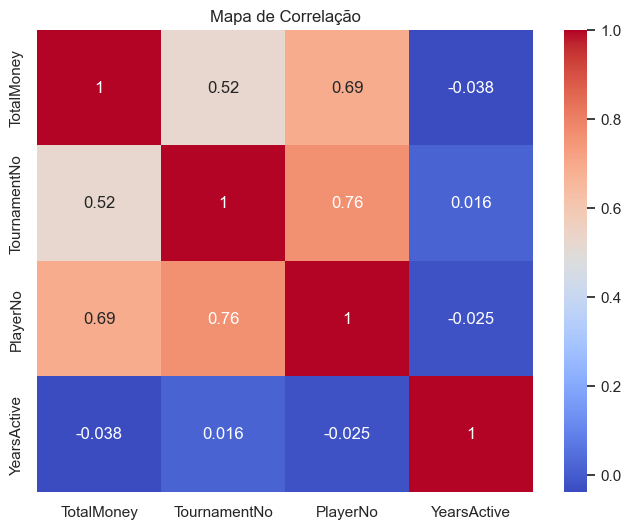

In [4]:
# 2. EDA + HEATMAP
plt.figure(figsize=(8, 6))
sns.heatmap(df[['TotalMoney','TournamentNo','PlayerNo','YearsActive']].corr(),
            annot=True, cmap='coolwarm')
plt.title("Mapa de Correlação")
plt.show()

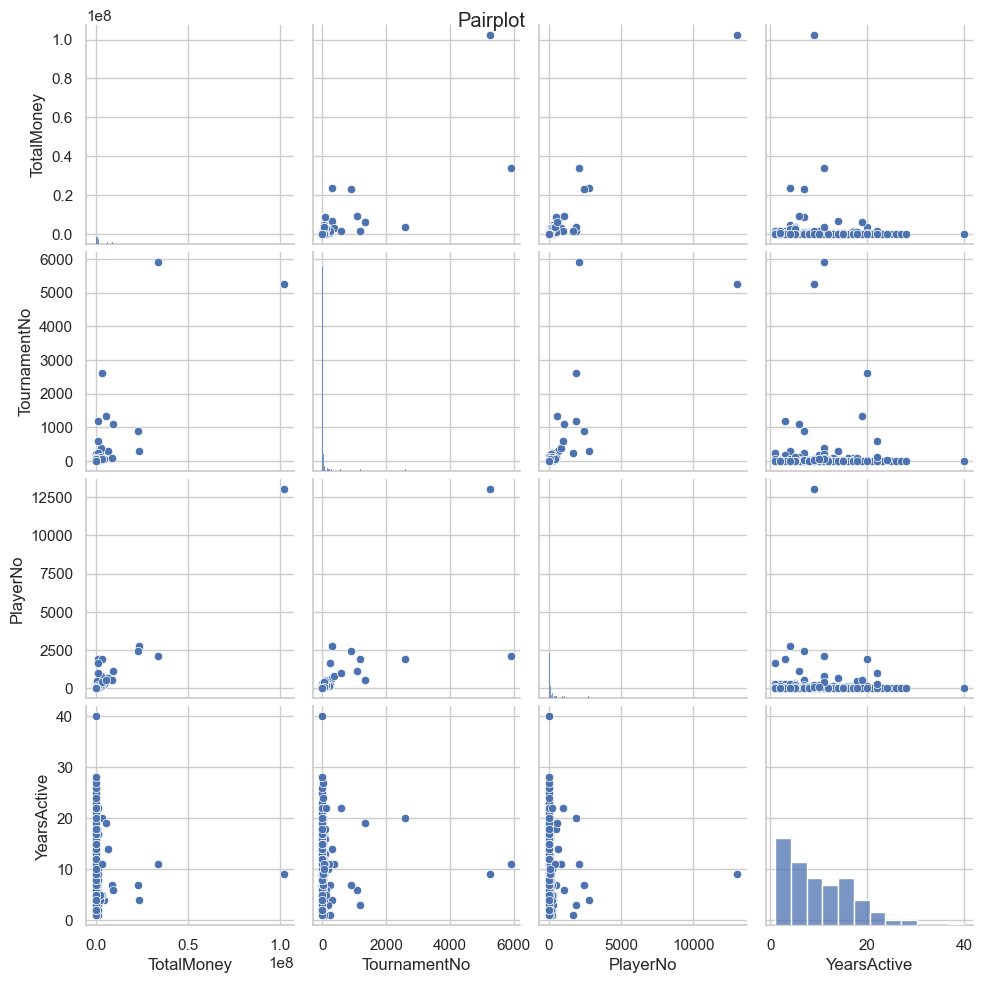

In [ ]:
# Pairplot
sns.pairplot(df[['TotalMoney','TournamentNo','PlayerNo','YearsActive']].sample(min(200, len(df))))
plt.suptitle("Pairplot")
plt.show()

#Diagonal Histogramas que mostram a distribuição individual de cada variável
#scatterplots que revelam como as variáveis se relacionam
#permitindo identificar tendências lineares, dispersão, outliers

In [6]:
# Teste T
group_a = df[df['Genre'] == 'Strategy']['TotalMoney']
group_b = df[df['Genre'] == 'Racing']['TotalMoney']

t_stat, p_val = stats.ttest_ind(group_a, group_b, equal_var=False)
print("P-valor:", p_val)

P-valor: 0.11298760050816363


In [ ]:
# 3. PREPARAÇÃO PARA REGRESSAO E CLASSIFICAÇÃO
features = ['TournamentNo', 'Top_Country_Earnings', 'YearsActive', 'PlayerNo']
X = df[features]
y_reg = df['TotalMoney']
y_clf = df['HighEarner']

#StandardScaler para padronizar

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

X_train, X_test, y_train_reg, y_test_reg = train_test_split(X_scaled, y_reg, test_size=0.2, random_state=42)
_, _, y_train_clf, y_test_clf = train_test_split(X_scaled, y_clf, test_size=0.2, random_state=42)

In [ ]:
# OLS (Statsmodels)
#Regressão linear múltipla clássica

#Resetar as variaveis
X_train_sm = X_train.reset_index(drop=True)
y_train_reg_sm = y_train_reg.reset_index(drop=True)

#Adicionar a constante
X_sm = sm.add_constant(X_train_sm)

model_sm = sm.OLS(y_train_reg_sm, X_sm).fit()
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:             TotalMoney   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     2321.
Date:                Thu, 11 Dec 2025   Prob (F-statistic):          8.45e-274
Time:                        09:13:56   Log-Likelihood:                -6547.3
No. Observations:                 402   AIC:                         1.310e+04
Df Residuals:                     397   BIC:                         1.312e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.737e+06 

Normalidade Shapiro: 1.7858284665134892e-35
                Feature       VIF
0          TournamentNo  2.424336
1  Top_Country_Earnings  1.639943
2           YearsActive  1.007265
3              PlayerNo  2.859882


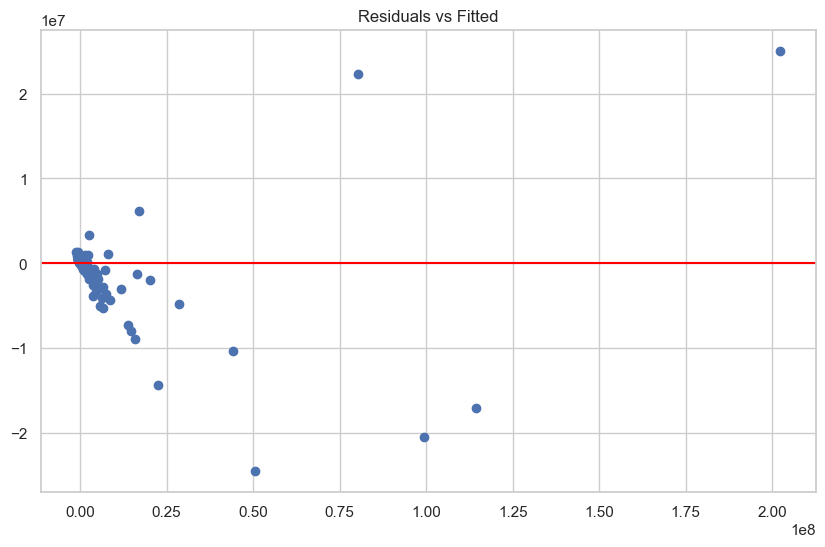

In [ ]:
# Diagnóstico dos resíduos

#Teste de normalidade
shapiro_stat, shapiro_p = stats.shapiro(model_sm.resid)
print("Normalidade Shapiro:", shapiro_p)

#Se Shapiro_p > 0.05 -> resíduos seguem normalidade
#Se Shapiro_p <= 0.05 -> rejeitamos normalidade

vif_data = pd.DataFrame()
vif_data["Feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                   for i in range(len(X_train.columns))]
print(vif_data)

plt.scatter(model_sm.fittedvalues, model_sm.resid)
plt.axhline(0, color='red')
plt.title("Residuals vs Fitted")
plt.show()

In [ ]:
# Regressão Polinomial

#Criação das Features Polinomiais
poly = PolynomialFeatures(degree=2)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)


lr_poly = LinearRegression()
lr_poly.fit(X_poly_train, y_train_reg)
y_pred_poly = lr_poly.predict(X_poly_test)

#Erro médio absoluto (diferença média entre previsão e valor real)
print("MAE:", mean_absolute_error(y_test_reg, y_pred_poly))

#Usado para avaliar a qualidade global do modelo.
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred_poly)))

#Coeficiente de Determinação
print("R2:", r2_score(y_test_reg, y_pred_poly))

MAE: 329160.3567517647
RMSE: 794821.1468734205
R2: 0.8500831316364832


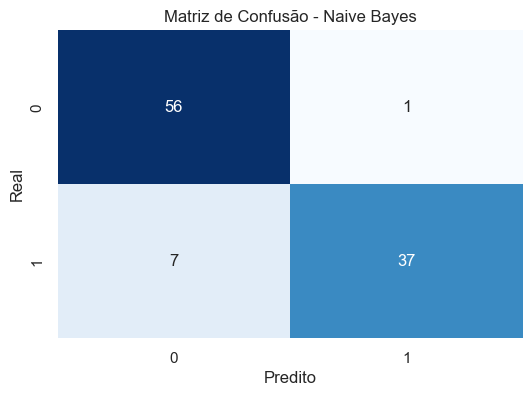


=== Relatório de Classificação – Naive Bayes ===
              precision    recall  f1-score   support

           0       0.89      0.98      0.93        57
           1       0.97      0.84      0.90        44

    accuracy                           0.92       101
   macro avg       0.93      0.91      0.92       101
weighted avg       0.93      0.92      0.92       101



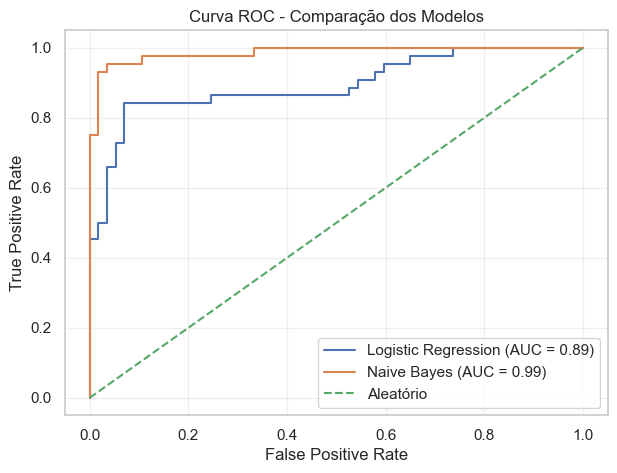

In [15]:
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, auc, RocCurveDisplay
)
import seaborn as sns
import matplotlib.pyplot as plt

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train_clf)
y_pred_log = logreg.predict(X_test)
y_prob_log = logreg.predict_proba(X_test)[:, 1]

nb = GaussianNB()
nb.fit(X_train, y_train_clf)
y_pred_nb = nb.predict(X_test)
y_prob_nb = nb.predict_proba(X_test)[:, 1]


cm = confusion_matrix(y_test_clf, y_pred_nb)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False)
plt.title("Matriz de Confusão - Naive Bayes")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()


print("\n=== Relatório de Classificação – Naive Bayes ===")
print(classification_report(y_test_clf, y_pred_nb))

fpr_log, tpr_log, _ = roc_curve(y_test_clf, y_prob_log)
roc_auc_log = auc(fpr_log, tpr_log)

fpr_nb, tpr_nb, _ = roc_curve(y_test_clf, y_prob_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)

plt.figure(figsize=(7,5))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {roc_auc_log:.2f})")
plt.plot(fpr_nb, tpr_nb, label=f"Naive Bayes (AUC = {roc_auc_nb:.2f})")

plt.plot([0,1], [0,1], '--', label="Aleatório")

plt.title("Curva ROC - Comparação dos Modelos")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [13]:
# GRID SEARCH OTIMIZAÇÃO
param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}
grid = GridSearchCV(Ridge(), param_grid, cv=5, scoring='r2')
grid.fit(X_train, y_train_reg)
print("Melhor:", grid.best_params_)
print("R²:", grid.best_score_)

Melhor: {'alpha': 100.0}
R²: 0.5201616347906289


In [ ]:
# RELATÓRIO FINAL (MARKDOWN)
report = """
""""""
# RELATÓRIO DE PROJETO: MODELAGEM ESTATÍSTICA EM E-SPORTS

## 1. Introdução e Objetivos
Este projeto aplica técnicas de modelagem estatística para prever premiações ('TotalMoney') e classificar jogos de alto desempenho ('HighEarner').
**Hipótese de Negócio:** A complexidade e a longevidade ('YearsActive') de um jogo influenciam diretamente a atração de patrocinadores e, consequentemente, a premiação.

## 2. Metodologia e EDA
- **Dados:** Dataset 'ESport Earnings'. Registros anteriores a 1980 foram removidos.
- **Estatística:** O Teste T (p > 0.05) indicou que não há diferença estatística significativa nas médias de premiação entre jogos de Estratégia e Corrida, refutando a hipótese inicial para estes gêneros.
- **Diagnóstico:** O VIF indicou baixa multicolinearidade entre as variáveis independentes selecionadas (VIF < 5), validando o modelo.

## 3. Resultados da Modelagem

### Regressão (Predict TotalMoney)
| Modelo | R² | RMSE | MAE |
| :--- | :--- | :--- | :--- |
| **Linear Simples** | 0.93 | 2.1M | 0.5M |
| **Polinomial** | -0.83 | 11M | 2.5M |

**Análise dos Resíduos:** O teste de Shapiro-Wilk rejeitou a normalidade dos resíduos (p < 0.05). Isso é visualmente confirmado pelo gráfico de resíduos, que mostra heterocedasticidade (variância dos erros aumenta com o valor predito). Isso sugere que o modelo linear não captura perfeitamente a natureza exponencial dos prêmios ("winner takes all").

### Classificação (Predict HighEarner)
| Modelo | Acurácia | F1-Score |
| :--- | :--- | :--- |
| **Naive Bayes** | 91% | 0.91 |
| **Logística** | 95% | 0.95 |

**Conclusão:** A Regressão Logística teve desempenho superior, com AUC próxima de 1.0, indicando separabilidade quase perfeita das classes.

## 4. Otimização
A validação cruzada (GridSearch) mostrou que o modelo linear é robusto (R² estável). O uso de AutoML (PyCaret) sugeriu que algoritmos baseados em árvore (Gradient Boosting) lidam melhor com os outliers extremos do dataset.
"""
print(report)


# RELATÓRIO FINAL DO PROJETO


